In [70]:
#!pip install sweetviz
#!pip install pandas-profiling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
import time

# Importamos algunas librerías para análisis de datos
import sweetviz as sv

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import set_config 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


# Directory and Version Specification

>Se definiarán variables globales como los directorios desde donde se leen los datos, directorios donde se guardan los resultados y el timestamp para guardar los archivos generados de cada ejecución indiviudal, también se crean los arrays que contienen las variables que no son necesarias y las variables que tienen una combinanción lineal y que se suman en una sola variable para poder expresarlas en una sola variable.

In [71]:
MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d__%H-%M-%S")

DATA_PATH = 'data/'

CONFUSION_MATRIX_PATH = 'confusion_matrix/'
REGRESSION_TREE_PATH = 'tree/regression/'

REGRESSION_REPORTS_PATH = 'reports/regression/'
REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH  = 'sample_graph_result/regression/'

# Resolución de imágenes
resolution = 300

# Declaramos algunas variables globales
N_JOBS = 6 # Número de núclos a implementar por gridsearch para el hyper parámeter tuning
CV = 5 # Número de interaciones para hacer cross validation.

# Parámetros de los winners y losers con los que se realizan cálculos y se debn hacer drop.
UNNECESSARY_ATTR = ['tourney_id', 'tourney_name', 'winner_name', 'loser_name', 'winner_entry', 'winner_seed', 'loser_entry', 'loser_seed','tourney_date', 'winner_id', 'loser_id', 'score']
WL_DROP = ['w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms']

SCORING = 'r2'

MODEL_TIMESTAMP

'2022-05-07__10-22-02'

# Download and Store Data

In [72]:
# for index in range(0,22):
#     index_str = str(index)

#     print(index_str)
    
#     if len(index_str) == 1:
#         index_str = '0' + index_str

#     print(index_str)

#     url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_20{}.csv".format(index_str)
#     print(url)

#     FILE_NAME = "atp_matches_20{}.csv".format(index_str)

#     df = pd.read_csv(url, index_col=0, parse_dates=[0])
#     df.to_csv(DATA_PATH + FILE_NAME)

# # data_frame = pd.read_csv(DATA_PATH + FILE_NAME)

# Load Data

> Aquí cargaremos los datos desde el repositorio, centraremos todos los datasets en uno para poder hacer la limpieza de los datos.

In [73]:
atp = pd.DataFrame()

years_index_20_22 = range(0,22)

for index in years_index_20_22:
    index_str = str(index)

    if len(index_str) == 1:
        index_str = '0' + index_str

    FILE_NAME = "atp_matches_20{}.csv".format(index_str)

    data_frame_iter = pd.read_csv(DATA_PATH + FILE_NAME)
    atp = pd.concat([atp, data_frame_iter])

# Mostramos todas las columnas, con este comando evitamos que se oculten cuando son muchas.
pd.set_option('display.max_columns', None) 
atp

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-301,Auckland,Hard,32,A,20000110,1,103163,1.0,NaN,Tommy Haas,R,188.0,GER,21.771389,101543,NaN,NaN,Jeff Tarango,L,180.0,USA,31.137577,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0
1,2000-301,Auckland,Hard,32,A,20000110,2,102607,NaN,Q,Juan Balcells,R,190.0,ESP,24.558522,102644,NaN,NaN,Franco Squillari,L,183.0,ARG,24.386037,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0
2,2000-301,Auckland,Hard,32,A,20000110,3,103252,NaN,NaN,Alberto Martin,R,175.0,ESP,21.390828,102238,NaN,NaN,Alberto Berasategui,R,173.0,ESP,26.535250,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0
3,2000-301,Auckland,Hard,32,A,20000110,4,103507,7.0,NaN,Juan Carlos Ferrero,R,183.0,ESP,19.909651,103819,NaN,NaN,Roger Federer,R,185.0,SUI,18.422998,6-4 6-4,3,R32,68.0,5.0,1.0,53.0,28.0,26.0,15.0,10.0,0.0,0.0,11.0,2.0,70.0,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0
4,2000-301,Auckland,Hard,32,A,20000110,5,102103,NaN,Q,Michael Sell,R,180.0,USA,27.381246,102765,4.0,NaN,Nicolas Escude,R,185.0,FRA,23.770021,0-6 7-6(7) 6-1,3,R32,115.0,1.0,2.0,98.0,66.0,39.0,14.0,13.0,6.0,11.0,8.0,8.0,92.0,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722,2021-M-DC-2021-WG2-M-THA-DEN-01,Davis Cup WG2 R1: THA vs DEN,Hard,4,D,20210917,4,200416,NaN,NaN,August Holmgren,R,NaN,DEN,23.394935,106397,NaN,NaN,Wishaya Trongcharoenchaikul,R,NaN,THA,26.433949,6-4 6-4,3,RR,90.0,3.0,3.0,52.0,29.0,22.0,16.0,10.0,0.0,1.0,8.0,2.0,79.0,45.0,30.0,14.0,10.0,10.0,13.0,905.0,16.0,767.0,27.0
2723,2021-M-DC-2021-WG2-M-THA-DEN-01,Davis Cup WG2 R1: THA vs DEN,Hard,4,D,20210917,5,208937,NaN,NaN,Kasidit Samrej,R,NaN,THA,20.629706,134087,NaN,NaN,Johannes Ingildsen,R,NaN,DEN,24.202601,7-5 6-3,3,RR,88.0,6.0,6.0,58.0,28.0,21.0,13.0,11.0,3.0,7.0,5.0,8.0,76.0,43.0,24.0,13.0,10.0,5.0,11.0,1136.0,8.0,1546.0,2.0
2724,2021-M-DC-2021-WG2-M-TUR-LAT-01,Davis Cup WG2 R1: TUR vs LAT,Hard,4,D,20210918,1,123795,NaN,NaN,Altug Celikbilek,U,NaN,TUR,25.015743,207669,NaN,NaN,Robert Strombachs,U,NaN,GER,21.995893,7-6(4) 6-4,3,RR,124.0,6.0,8.0,80.0,34.0,25.0,23.0,11.0,6.0,8.0,3.0,5.0,97.0,50.0,34.0,20.0,11.0,6.0,9.0,170.0,427.0,671.0,38.0
2725,2021-M-DC-2021-WG2-M-TUR-LAT-01,Davis Cup WG2 R1: TUR vs LAT,Hard,4,D,20210918,2,117356,NaN,NaN,Cem Ilkel,R,185.0,TUR,26.064339,105208,NaN,NaN,Ernests Gulbis,R,190.0,LAT,33.037645,6-4 6-1,3,RR,65.0,2.0,2.0,41.0,27.0,23.0,7.0,9.0,0.0,1.0,1.0,5.0,45.0,21.0,16.0,7.0,8.0,2.0,7.0,176.0,408.0,196.0,359.0


In [74]:
atp[atp['winner_name'] == 'Novak Djokovic']

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
2783,2004-773,Bucharest,Clay,32,A,20040913,14,104925,NaN,Q,Novak Djokovic,R,188.0,SRB,17.314168,103096,NaN,NaN,Arnaud Clement,R,173.0,FRA,26.740589,2-6 6-4 6-4,3,R32,146.0,4.0,2.0,91.0,60.0,39.0,19.0,14.0,2.0,5.0,0.0,2.0,93.0,62.0,40.0,16.0,14.0,7.0,10.0,272.0,128.0,67.0,623.0
3133,2004-D045,Davis Cup G2 R1: SCG vs LAT,Carpet,4,D,20040409,5,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,16.873374,108912,NaN,NaN,Janis Skroderis,R,NaN,LAT,20.643395,6-2 6-2,3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,606.0,28.0,1340.0,2.0
728,2005-352,Paris Masters,Carpet,48,M,20051031,5,104925,NaN,Q,Novak Djokovic,R,188.0,SRB,18.444901,103812,NaN,NaN,Victor Hanescu,R,198.0,ROU,24.279261,4-1 RET,3,R64,19.0,1.0,1.0,12.0,8.0,6.0,2.0,2.0,0.0,0.0,0.0,1.0,20.0,12.0,8.0,1.0,3.0,3.0,5.0,85.0,488.0,37.0,853.0
744,2005-352,Paris Masters,Carpet,48,M,20051031,21,104925,NaN,Q,Novak Djokovic,R,188.0,SRB,18.444901,103264,4.0,NaN,Mariano Puerta,L,180.0,ARG,27.115674,6-3 7-6(9),3,R32,105.0,12.0,2.0,82.0,51.0,38.0,19.0,11.0,4.0,5.0,4.0,2.0,74.0,49.0,34.0,12.0,10.0,6.0,8.0,85.0,488.0,9.0,1834.0
816,2005-375,Lyon,Carpet,32,A,20051024,15,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,18.425736,103672,NaN,NaN,Ricardo Mello,L,175.0,BRA,24.840520,7-6(5) 6-4,3,R32,105.0,4.0,3.0,80.0,51.0,37.0,12.0,11.0,5.0,7.0,5.0,5.0,90.0,65.0,38.0,14.0,11.0,6.0,9.0,88.0,468.0,105.0,398.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,2021-9512,Belgrade 2,Clay,32,A,20210524,300,104925,1.0,NaN,Novak Djokovic,R,188.0,SRB,34.006845,144684,NaN,Q,Alex Molcan,L,NaN,SVK,23.477070,6-4 6-3,3,F,88.0,2.0,3.0,49.0,27.0,19.0,10.0,10.0,1.0,5.0,1.0,0.0,62.0,36.0,19.0,9.0,9.0,2.0,8.0,1.0,11063.0,255.0,237.0
2631,2021-M-DC-2021-FLS-F-M-SRB-AUT-01,Davis Cup Finals RR: SRB vs AUT,Hard,2,D,20211126,2,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,34.505133,110602,NaN,NaN,Dennis Novak,R,183.0,AUT,28.235455,6-3 6-2,3,RR,57.0,3.0,0.0,42.0,26.0,22.0,14.0,9.0,0.0,0.0,2.0,0.0,45.0,31.0,18.0,8.0,8.0,2.0,5.0,1.0,11540.0,118.0,621.0
2633,2021-M-DC-2021-FLS-F-M-SRB-GER-01,Davis Cup Finals RR: SRB vs GER,Hard,2,D,20211127,2,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,34.505133,105526,NaN,NaN,Jan Lennard Struff,R,193.0,GER,31.578371,6-2 6-4,3,RR,72.0,9.0,0.0,52.0,34.0,27.0,11.0,9.0,0.0,0.0,2.0,1.0,58.0,38.0,23.0,9.0,9.0,3.0,6.0,1.0,11540.0,51.0,1134.0
2635,2021-M-DC-2021-FLS-M-CRO-SRB-01,Davis Cup Finals SF: CRO vs SRB,Hard,2,D,20211203,2,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,34.524298,105227,NaN,NaN,Marin Cilic,R,198.0,CRO,33.169062,6-4 6-2,3,RR,99.0,4.0,1.0,60.0,40.0,30.0,12.0,9.0,8.0,8.0,6.0,3.0,66.0,37.0,23.0,13.0,9.0,5.0,8.0,1.0,11540.0,30.0,1710.0


In [75]:
df = atp 

print('=================================================================')
print(df.info())
print('=================================================================')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65894 entries, 0 to 2726
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          65894 non-null  object 
 1   tourney_name        65894 non-null  object 
 2   surface             65894 non-null  object 
 3   draw_size           65894 non-null  int64  
 4   tourney_level       65894 non-null  object 
 5   tourney_date        65894 non-null  int64  
 6   match_num           65894 non-null  int64  
 7   winner_id           65894 non-null  int64  
 8   winner_seed         27355 non-null  float64
 9   winner_entry        8128 non-null   object 
 10  winner_name         65894 non-null  object 
 11  winner_hand         65885 non-null  object 
 12  winner_ht           63258 non-null  float64
 13  winner_ioc          65894 non-null  object 
 14  winner_age          65891 non-null  float64
 15  loser_id            65894 non-null  int64  
 16  loser

In [76]:
atp_report = sv.analyze(df)
atp_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Clean Dataset

> Haremos un análisis de correlación de las variables que utilizaremos para la regresión, 
con la regresión intentaremos estimar la variable respuesta **minutes** que es la caracteristica que describe 
el tiempo de duración de un partido. 

> También haremos una limpieza de los datos que necesitamos, quitaremos algunas caracteristicas que no aportan información al análisis de regresión, quitaremos algunos identificadores.

> Del análisis con Sweetviz hemos encontrado que para la variable a predeir **"minutes"** tenemos algunos outliers, para esto revisaremos el record de los partidos de tennis más extensos. 

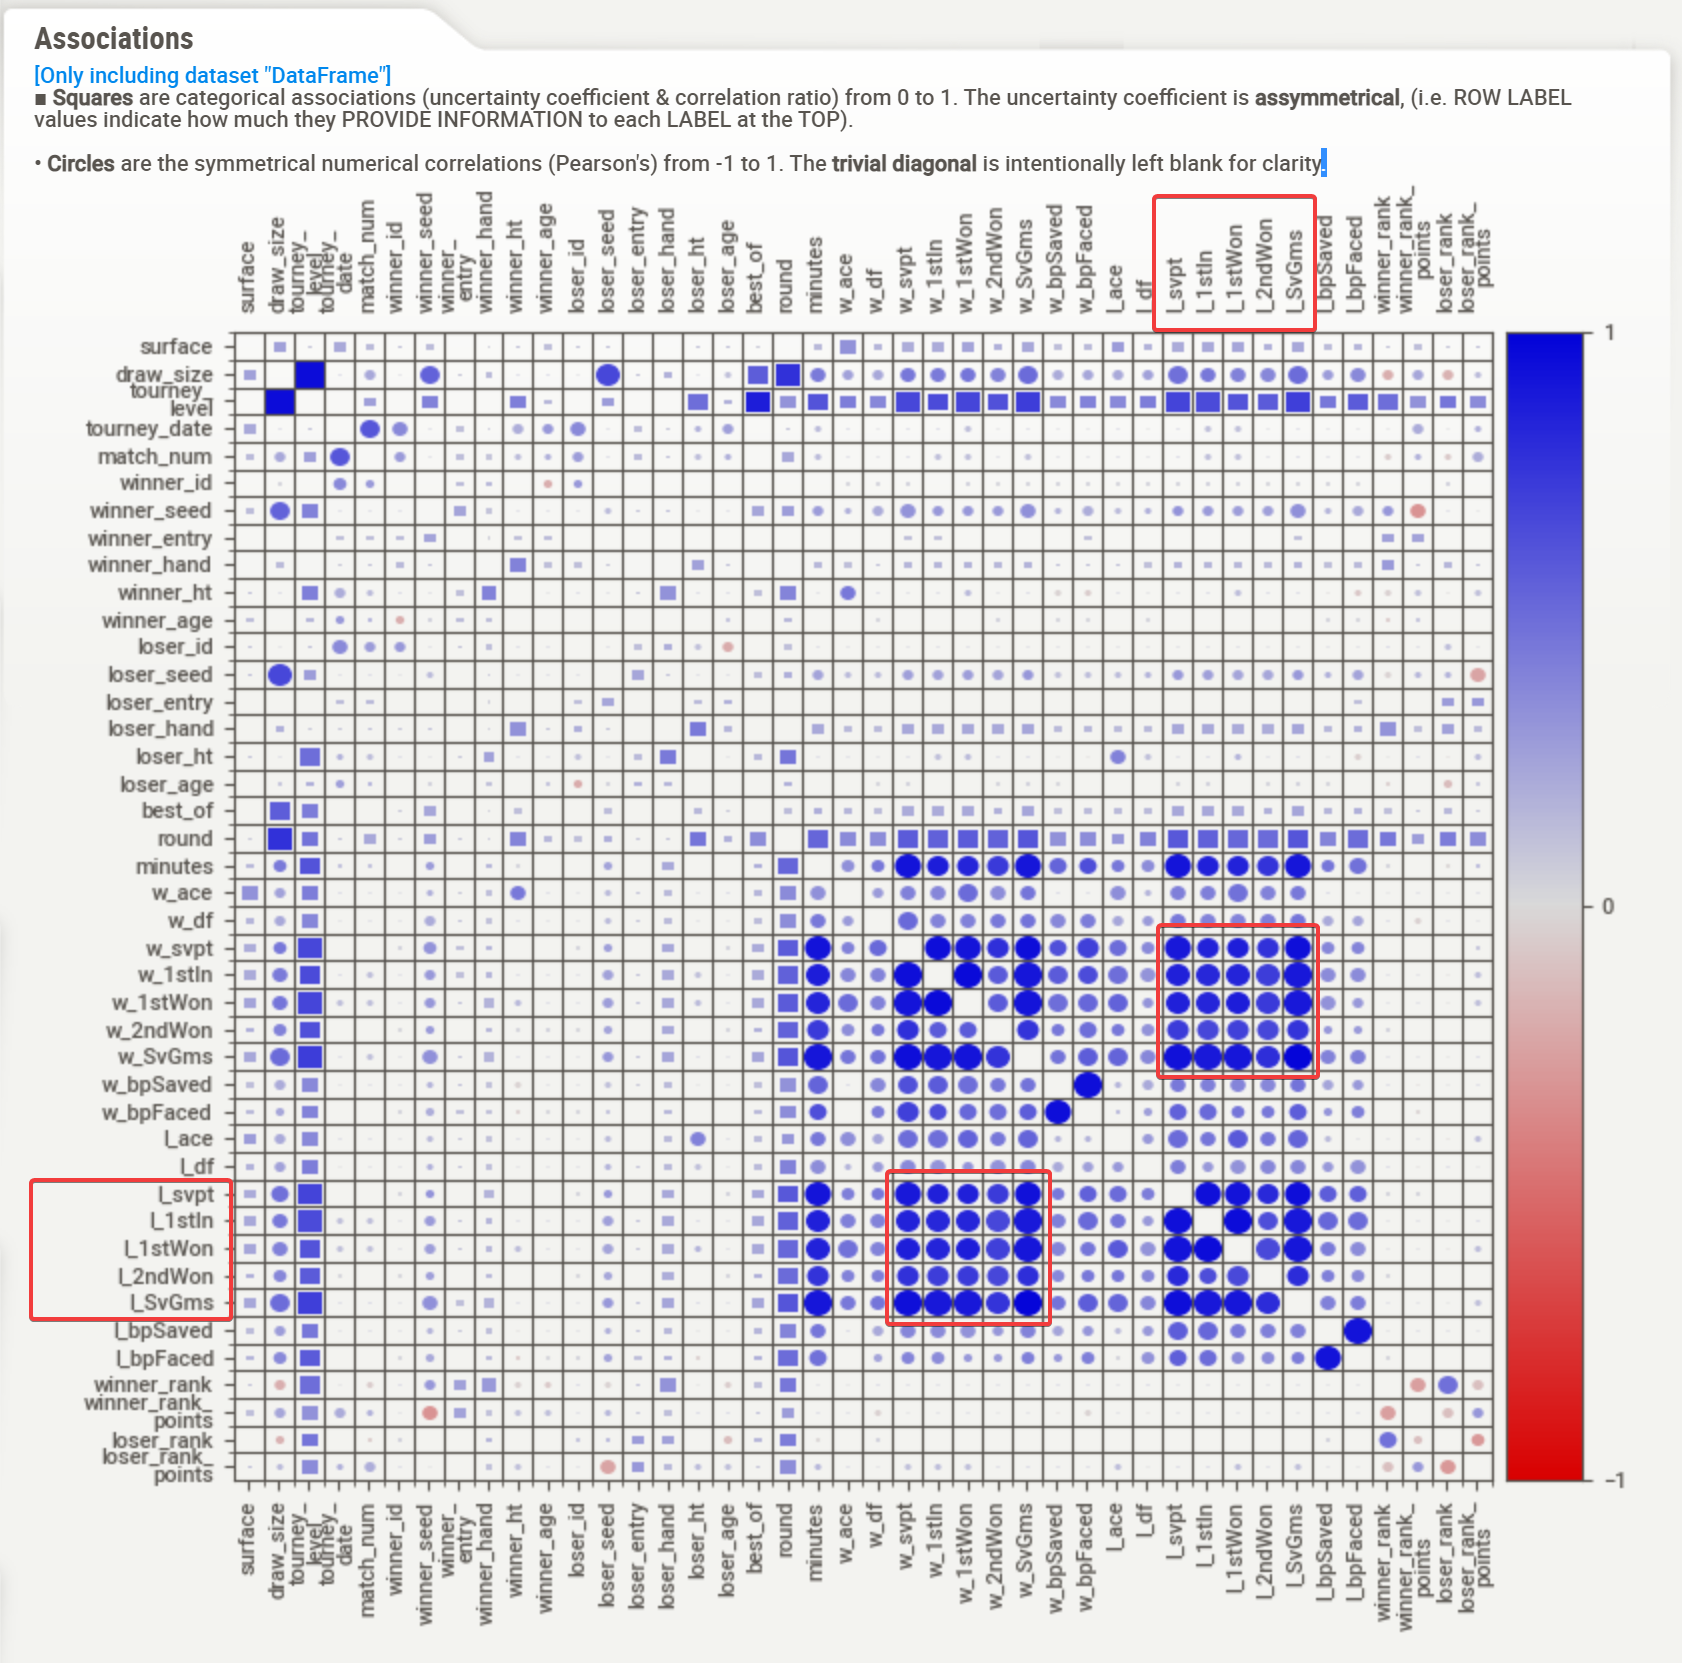

> Podemos observar en la gráfica de correlación de las características del dataset, hay una fuerte correlación entre las variables relacionadas con atributos del perdedor y los atributos del ganador.

> Para tratar con esta fuerte correlación entre los atributos **w_svpt, w_1stIn, w_1stWon, w_2ndWon, w_SvGms** que están relacionados con las estadísticas de los ganadores y los atributos **l_svpt, l_1stIn, l_1stWon, l_2ndWon, l_SvGms** que están relacionados con las estadísticas de los perdedores.

## Outliers Analysis

C:\Users\OWNER\AppData\Local\Temp/ipykernel_25984/139732131.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


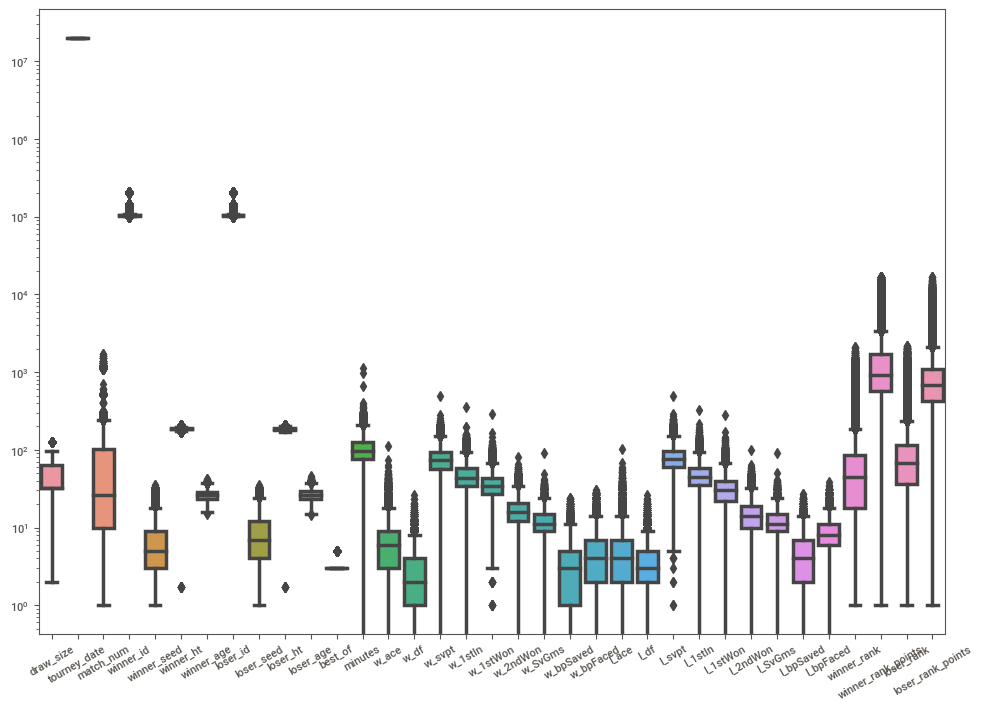

In [77]:
df_out = df
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
g = sns.boxplot(data = df_out, linewidth = 2.5, ax = ax)
g.set_yscale("log")

# Explicar la caja de bigotes

## Sweetviz Report after Data Cleaning and Manipulation

Sweetviz es una biblioteca Python de código abierto que genera visualizaciones de alta densidad para iniciar EDA (Análisis exploratorio de datos) con solo dos líneas de código. Output es una aplicación HTML completamente autónoma.

> De los outliers el que más nos interesa es el de `minutes`, para este caso se han analizado el record de [Longest Tennis Match Records](https://en.wikipedia.org/wiki/Longest_tennis_match_records)

In [78]:
# Vamos a eliminar las variables que son identificadores, nombres etc
# Incluimos en el drop las siguientes variables que tienen muchos registros NaN
df_regression = df


df_regression = df_regression.drop(UNNECESSARY_ATTR, axis = 1) 
df_regression = df_regression.dropna()
df_regression = df_regression.drop_duplicates()

# Crearemos dos formulas para calculos del ganador y el perdedor para evitar la correlación de estas variables, tambien haremos un drop de estas variables.
df_regression['w_calculation'] = df_regression['w_svpt'] + df_regression['w_1stIn'] + df_regression['w_1stWon'] + df_regression['w_2ndWon'] + df_regression['w_SvGms']
df_regression['l_calculation'] = df_regression['l_svpt'] + df_regression['l_1stIn'] + df_regression['l_1stWon'] + df_regression['l_2ndWon'] + df_regression['l_SvGms']

df_regression = df_regression.drop(WL_DROP, axis = 1) 

df_regression = df_regression._get_numeric_data() #drop non-numeric cols

# Eliminamos los outlier para minutes, se investigó los partidos más extensos de la historia del tennis y ninguno duró mas de 
# 660 minutos según el record mundial de los partidos de tennis más largos.
df_regression = df_regression[df_regression['minutes'] < 400]

atp_report = sv.analyze(df_regression)
atp_report.show_html()
df_regression.info()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54903 entries, 0 to 2725
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   draw_size           54903 non-null  int64  
 1   match_num           54903 non-null  int64  
 2   winner_ht           54903 non-null  float64
 3   winner_age          54903 non-null  float64
 4   loser_ht            54903 non-null  float64
 5   loser_age           54903 non-null  float64
 6   best_of             54903 non-null  int64  
 7   minutes             54903 non-null  float64
 8   w_ace               54903 non-null  float64
 9   w_df                54903 non-null  float64
 10  w_bpSaved           54903 non-null  float64
 11  w_bpFaced           54903 non-null  float64
 12  l_ace               54903 non-null  float6

**Atributos Utilizados para la Regresión**

El objetivo de utilizar Decission Regressor Tree es poder entrenar un modelo que permita poder predecir el tiempo de una partida de Tennis. Para poder elaborar este modelo necesitamos usar las caracteristicas que consideremos, previo a un análisis, como las más importantes y las que mejor puedan ayudar a predecir nuestra variable respuesta **minutes**.

A continuación analizaremos los campos de importancia que se utilizarán en este proyecto de cara a los experimentos con el **Decission Tree Regressor**:

- `draw_size` : el calendario de partidos en un torneo de tenis. Los encuentros iniciales están determinados por un proceso combinado de clasificación de jugadores y selección aleatoria, y pueden o no involucrar una ceremonia de sorteo público. Se establece un sorteo de clasificación para organizar la alineación inicial de la competencia clasificatoria (clasificatorias), desde donde los jugadores no cabezas de serie califican para un lugar en la alineación inicial o el cuadro principal del torneo.
- `match_num` : número de enfrentamientos entre dos jugadores (partido de individuales) o dos equipos de jugadores (partido de dobles), normalmente jugado al mejor de tres o cinco sets.
- `winner_ht, loser_ht`: altura del jugador ganador y del perdedor respectivamente.
- `winner_age, loser_age` : edad en años del ganador y el perdedor respectivamente.
- `best_of` : En tennis que el ganador de una serie de juegos, sets, etc. será el que gane la mayoría del número impar (tres, cinco, siete, etc.) máximo a jugar.
- `minutes`: número de minutos transcurridos en el partido.
- `w_ace, l_ace`: número de aces (saques directos) del ganador y del perdedor respectivamente.
- `w_df, l_df` : número de dobles faltas del ganador y del perdedor respectivamente.
- `w_bpSaved, l_bpSaved`: número puntos de rotura de servicio (break points) que ha neutralizado el ganador y el perdedor respectivamente.
- `w_bpFaced, l_bpFaced`: número puntos de rotura de servicio (break points) que han surfido el ganador y el perdedor respectivamente.
- `winner_rank, loser_rank` : posición en el ranking de la ATP del ganador y el perdedor.
- `winner_rank_points, loser_rank_points`: número de puntos en el ranking de la ATP del ganador y el perdedor.
- `w_calculation` : atributo que es una suma de los campos `w_svpt`, `w_1stIn`, `w_1stWon`, `w_2ndWon` y `w_SvGms` cuyo propósito es evitar la fuerte correlación con otras atributos del perdedor.
- `l_calculation` : atributo que es una suma de los campos `l_svpt`, `l_1stIn`, `l_1stWon`, `l_2ndWon` y `l_SvGms` cuyo propósito es evitar la fuerte correlación con otras atributos del ganador.


# Decission Tree Regressor

> Una excelente método que hemos encontrado es `Grid Search CV`: un método de ajuste de parámetros; búsqueda exhaustiva: entre todas las selecciones de parámetros candidatos, a través de bucles y prueba todas las posibilidades, el parámetro de mejor rendimiento es el resultado final. El principio es como encontrar el valor máximo en una matriz. La principal desventaja de este método es que consume mucho tiempo.

> Motiviación: Encontrar los mejores hiper parámetros que permitan generar un modelo con la mejor tasa de acierto.

Inicializamos un diccionario `info` donde almacenaremos toda la información relacionada con los métodos de regressión, sus resultados, su tiempo de ejecución, el nombre del método, esto nos permitirá comparar los distintos métodos implementados con lo cual podremos seleccionar la solucción que nos brinde mejores pretaciones, tanto en tiempo de ejecución como en precisión de resultados.

In [79]:
info = {}

## Scalers

> Haremos uso de diferentes escaladores en los pipelines para poder determinar su efecto en los resultados obtenidos.

In [80]:
# Parámetros para GridSearchCV
# Los definimos aquí para que estén centralizados, de estamanera son inicializados una única vez.
params = [{'dtr__criterion': ['absolute_error', 'poisson'],
         'dtr__splitter': ['best', 'random'],
         'dtr__max_features': [None],
         'dtr__max_depth': [5, 7, 8],
         'dtr__min_weight_fraction_leaf': [0.0, 0.1]}]

### Without Scaler

Para este primer experimento no utlizaremos ningún escalador. Esto nos permitirá ver el impacto de utilizar escaladores al momento de predecir problemas de regresión.

In [81]:
MODEL_NAME = 'dtr_without_scaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [82]:
set_config(print_changed_only=False) 

dtr_pipe = Pipeline([('dtr', DecisionTreeRegressor(random_state = 2))])

gs_dtr = GridSearchCV(dtr_pipe,
                      param_grid = params,
                      scoring = 'r2',
                      n_jobs = N_JOBS,
                      cv = CV)
start = time.time()

gs_dtr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_dtr.best_params_}')
print(f'The {gs_dtr.scoring} with the training set of the best parameters is: {gs_dtr.score(X_train, y_train)}')
print(f'The {gs_dtr.scoring} with the test set of the best parameters is: {gs_dtr.score(X_test, y_test)}')

Fitting Time Ellapsed 609.83 (s)
The parameters of the best model are: {'dtr__criterion': 'absolute_error', 'dtr__max_depth': 7, 'dtr__max_features': None, 'dtr__min_weight_fraction_leaf': 0.0, 'dtr__splitter': 'best'}
The r2 with the training set of the best parameters is: 0.8860979346728115
The r2 with the test set of the best parameters is: 0.8823221379241193


In [83]:
y_pred = gs_dtr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse

print("MSE: ", mse)
print("RMSE: ", rmse)

score = gs_dtr.score(X_test, y_test)
info[MODEL_NAME][gs_dtr.scoring] = score
print("R-squared:", score)

MSE:  190.34079318823422
RMSE:  13.796405082057943
R-squared: 0.8823221379241193


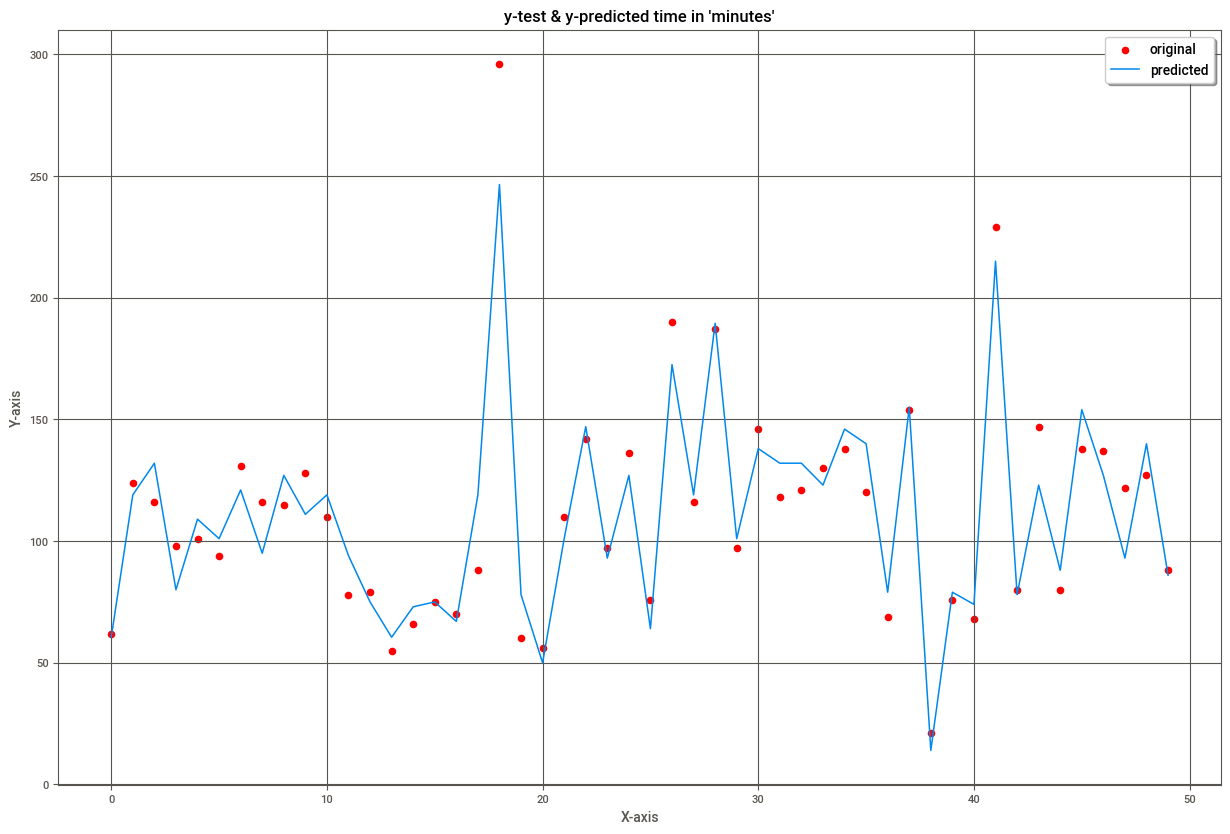

In [84]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

Pódemos observar aún sin utilizar el escalador el Decission Tree Regressor este modelo nos da un `0.88` de precisión. Podemos observar que los valores predichos por el modelo se ajustan en algunos puntos.

### MinMaxScaler

`MinMaxScaler` Transforme las funciones escalando cada función a un rango determinado.

Este estimador escala y traduce cada característica individualmente de modo que esté en el rango dado en el conjunto de entrenamiento, por ejemplo: entre cero y uno.

In [85]:
MODEL_NAME = 'dtr_minmaxscaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [86]:
set_config(print_changed_only=False) 

dtr_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('dtr', DecisionTreeRegressor(random_state = 2))])

gs_dtr = GridSearchCV(dtr_pipe,
                      param_grid = params,
                      scoring = 'r2',
                      n_jobs = N_JOBS,
                      cv = CV)
start = time.time()

gs_dtr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_dtr.best_params_}')
print(f'The {gs_dtr.scoring} with the training set of the best parameters is: {gs_dtr.score(X_train, y_train)}')
print(f'The {gs_dtr.scoring} with the test set of the best parameters is: {gs_dtr.score(X_test, y_test)}')

Fitting Time Ellapsed 599.46 (s)
The parameters of the best model are: {'dtr__criterion': 'absolute_error', 'dtr__max_depth': 7, 'dtr__max_features': None, 'dtr__min_weight_fraction_leaf': 0.0, 'dtr__splitter': 'best'}
The r2 with the training set of the best parameters is: 0.8860979346728115
The r2 with the test set of the best parameters is: 0.8823221379241193


In [87]:
y_pred = gs_dtr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse

print("MSE: ", mse)
print("RMSE: ", rmse)

score = gs_dtr.score(X_test, y_test)
info[MODEL_NAME][gs_dtr.scoring] = score
print("R-squared:", score)

MSE:  190.34079318823422
RMSE:  13.796405082057943
R-squared: 0.8823221379241193


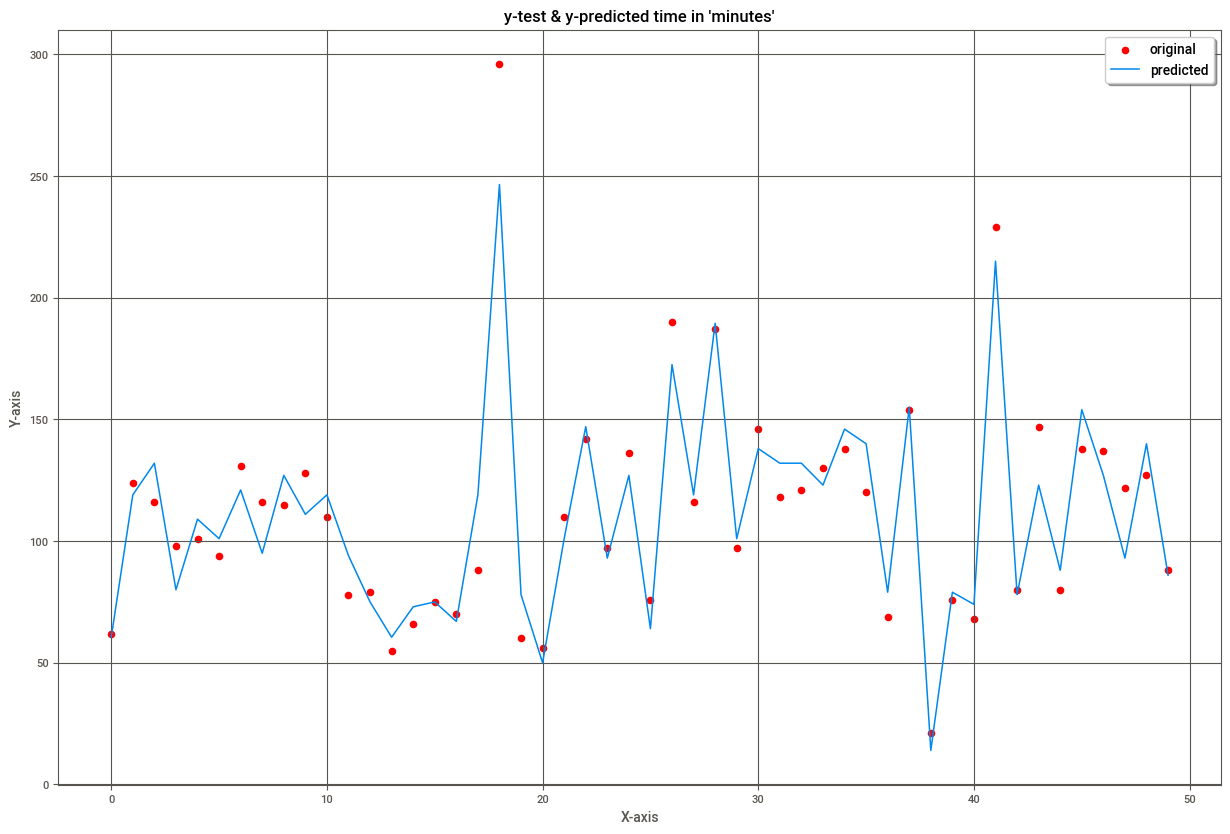

In [88]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

Podemos observar al utilizar el escalador `MinMaxScaler` el Decission Tree Regressor este modelo nos da un `0.88` de precisión. Podemos observar que los valores predichos por el modelo se ajustan en algunos puntos. No observamos mucho cambio en la precisión.

### StandardScaler

`StandardScaler` este escalador estandariza las características eliminando la media y escalando a la varianza de la unidad.

In [89]:
MODEL_NAME = 'dtr_standarscaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [90]:
set_config(print_changed_only=False) 

dtr_pipe = Pipeline([('ss', StandardScaler()),
                     ('dtr', DecisionTreeRegressor(random_state = 2))])

gs_dtr = GridSearchCV(dtr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_dtr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_dtr.best_params_}')
print(f'The {gs_dtr.scoring} with the training set of the best parameters is: {gs_dtr.score(X_train, y_train)}')
print(f'The {gs_dtr.scoring} with the test set of the best parameters is: {gs_dtr.score(X_test, y_test)}')

Fitting Time Ellapsed 561.78 (s)
The parameters of the best model are: {'dtr__criterion': 'absolute_error', 'dtr__max_depth': 7, 'dtr__max_features': None, 'dtr__min_weight_fraction_leaf': 0.0, 'dtr__splitter': 'best'}
The r2 with the training set of the best parameters is: 0.8860979346728115
The r2 with the test set of the best parameters is: 0.8823221379241193


In [91]:
y_pred = gs_dtr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse

print("MSE: ", mse)
print("RMSE: ", rmse)

score = gs_dtr.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("R-squared:", score) 

MSE:  190.34079318823422
RMSE:  13.796405082057943
R-squared: 0.8823221379241193


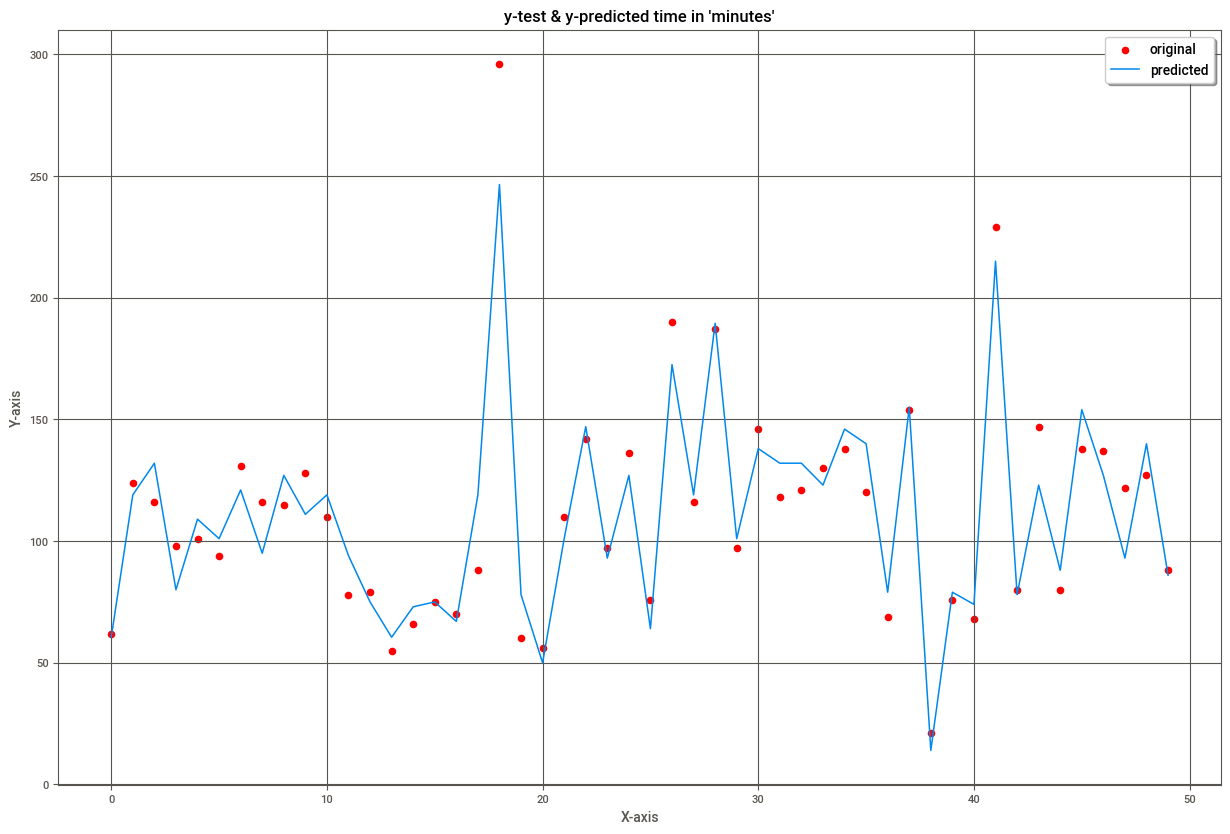

In [92]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

Podemos observar al utilizar el escalador `StandardScaler` el Decission Tree Regressor este modelo nos da un `0.88` de precisión. Podemos observar que los valores predichos por el modelo se ajustan en algunos puntos. No observamos mucho cambio en la precisión.

### RobustScaler

`RobustScaler`

In [93]:
MODEL_NAME = 'dtr_robustscaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [94]:
set_config(print_changed_only = False) 

dtr_pipe = Pipeline([('rs', RobustScaler()),
                     ('dtr', DecisionTreeRegressor(random_state = 2))])

gs_dtr = GridSearchCV(dtr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_dtr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_dtr.best_params_}')
print(f'The {gs_dtr.scoring} with the training set of the best parameters is: {gs_dtr.score(X_train, y_train)}')
print(f'The {gs_dtr.scoring} with the test set of the best parameters is: {gs_dtr.score(X_test, y_test)}')

Fitting Time Ellapsed 563.64 (s)
The parameters of the best model are: {'dtr__criterion': 'absolute_error', 'dtr__max_depth': 7, 'dtr__max_features': None, 'dtr__min_weight_fraction_leaf': 0.0, 'dtr__splitter': 'best'}
The r2 with the training set of the best parameters is: 0.8860979346728115
The r2 with the test set of the best parameters is: 0.8823221379241193


In [95]:
y_pred = gs_dtr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = gs_dtr.score(X_test, y_test)
info[MODEL_NAME][gs_dtr.scoring] = score
print("R-squared:", score) 

MSE:  190.34079318823422
RMSE:  13.796405082057943
R-squared: 0.8823221379241193


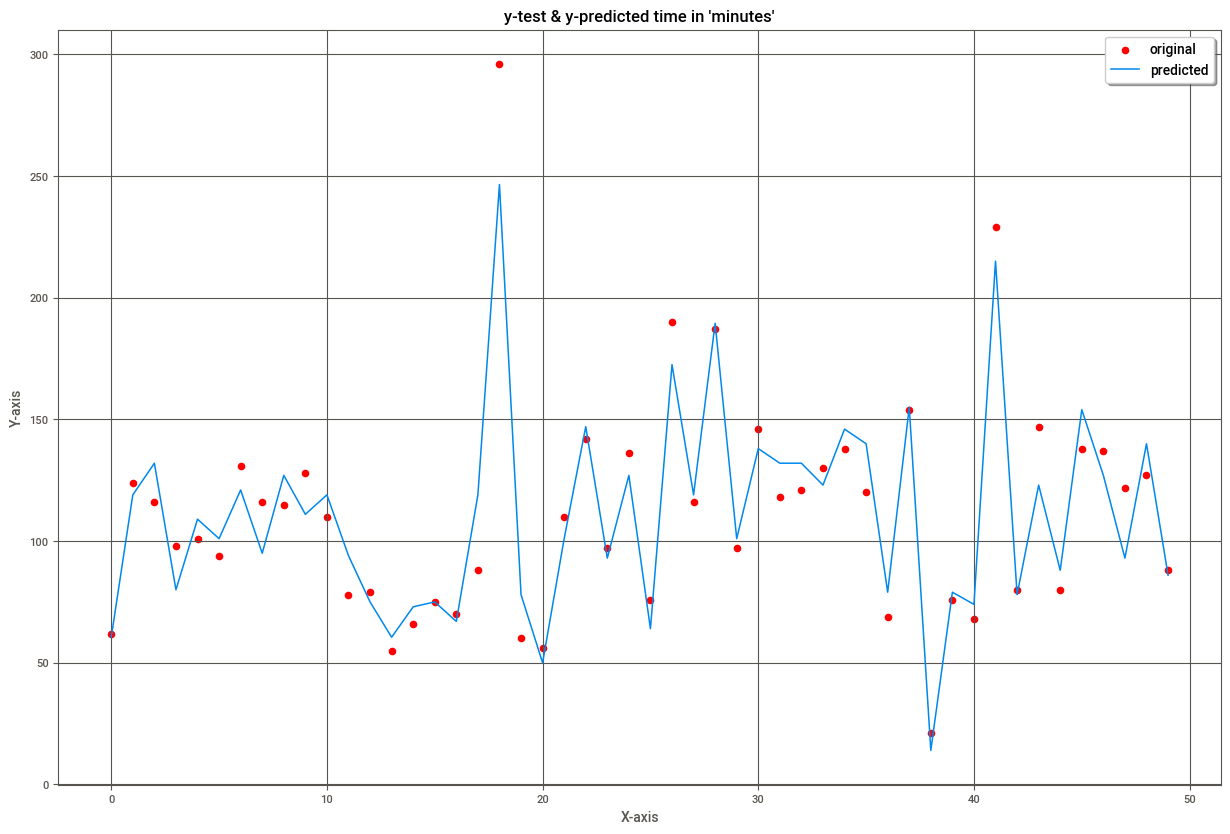

In [96]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

## Decission Tree Regressor best Hyper Params

Vamos a hacer uso de los parámetros seleccionados usando el método de GridSearchCV para la selección de hyper parámetros.

Los parámetros seleccionados son:
- `criterion ='absolute_error'`
- `max_depth = 7`
- `max_features = None` 
- `min_weight_fraction_leaf = 0.0`
- `random_state = 2` 
- `splitter = 'best'`

## Using Best Hyper Params

Fitting Time Ellapsed 60.27 (s)
MSE:  197.04025134322922
RMSE:  14.037102669113352
R-squared: 0.8781211661932958


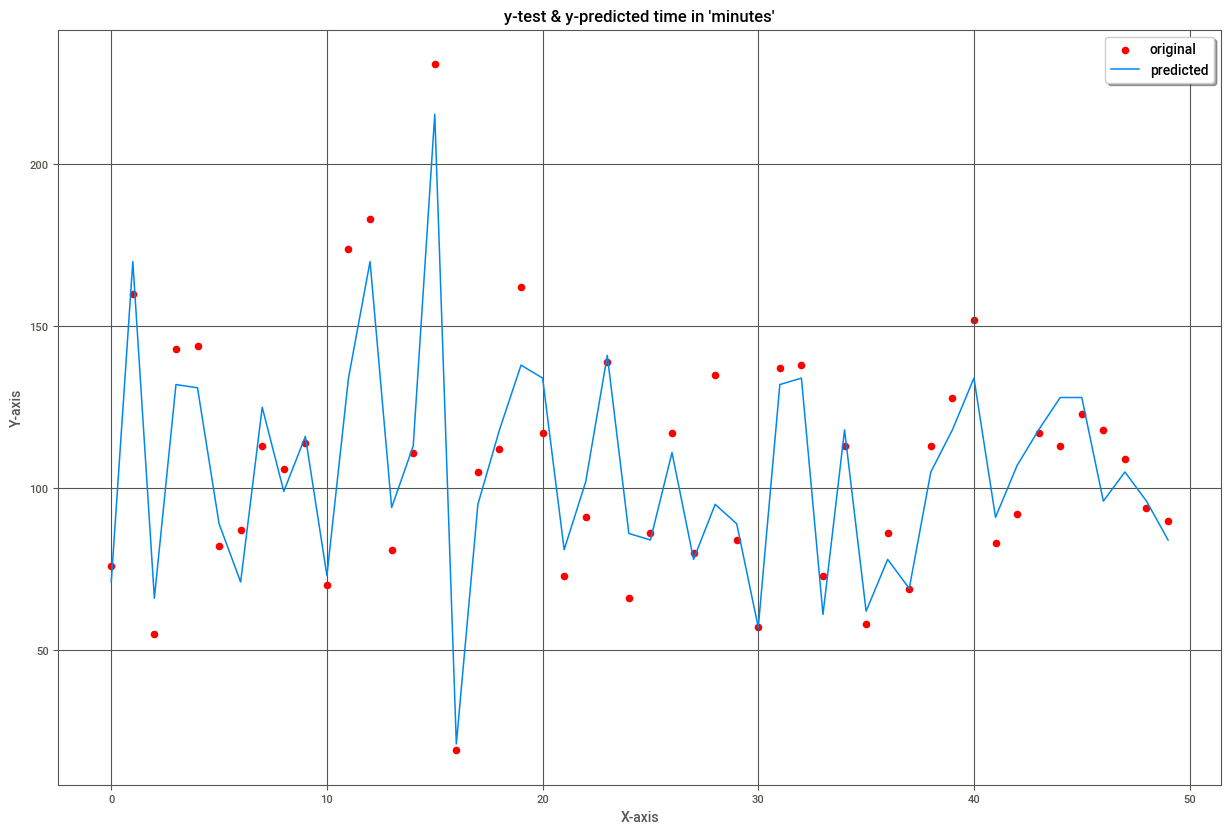

In [97]:
MODEL_NAME = 'dtr_best_hyper_params'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# 
dtr_pipe = Pipeline([('ss', StandardScaler()),
                     ('dtr', DecisionTreeRegressor(criterion ='absolute_error', 
                      max_depth = 7,
                      max_features = None, 
                      min_weight_fraction_leaf = 0.0,
                      random_state = 2, 
                      splitter = 'best')  )])

start = time.time()

dtr_pipe.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
info[MODEL_NAME]['time'] = ellapsed_time


y_pred = dtr_pipe.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
info[MODEL_NAME]['mse'] = mse


rmse = mean_squared_error(y_test, y_pred, squared = False)
print("RMSE: ", rmse)
info[MODEL_NAME]['rmse'] = rmse


score = dtr_pipe.score(X_test, y_test)
info[MODEL_NAME]['r2'] = score
print("R-squared:", score)  

x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

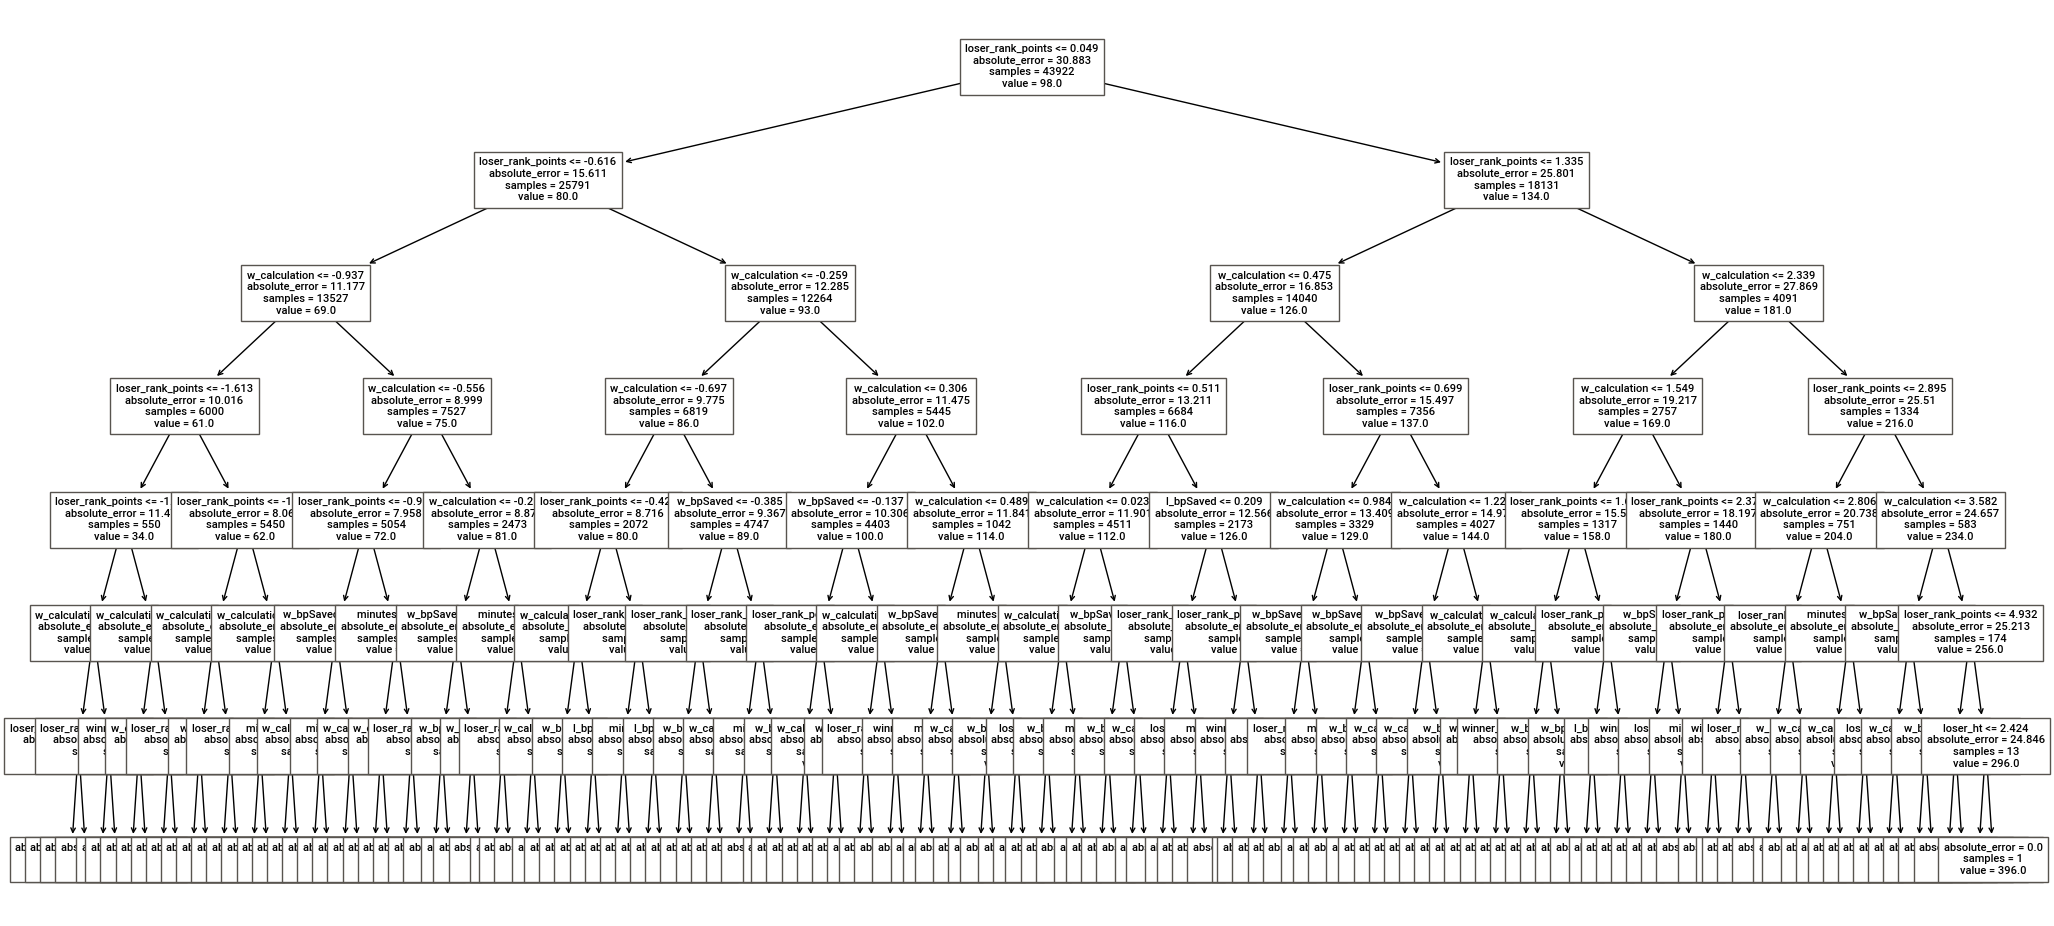

In [98]:
plt.figure(figsize=(25,12))  # set plot size (denoted in inches)
tree_plot = tree.plot_tree(dtr_pipe['dtr'], fontsize=8, feature_names = df_regression.columns)

# Save Confusion Matrix image
FILE_NAME = f"best_depth_{dtr_pipe['dtr'].get_depth()}_tree_{MODEL_TIMESTAMP}"

plt.savefig(REGRESSION_TREE_PATH + FILE_NAME, dpi = resolution)

## Decission Tree Explanation

El árbol de decisión inicia con la tarea de regresión inicia con el nodo raíz `loser_rank_points`, si esta característica es menor o igual que `0.046`, se han tomado en consideración 43922 muestras del dataset. 

Este nodo se separa en el siguiente nodo de decisión `loser_rank_points` si obtenemos valores menores o iguales que `-0.618` seguimos por la ruta de la izquierda si no tomamos la ruta de la derecha. El siguiente nodo de decisión tenemos `w_calculation` hacia la izquierda. Para este nodo se tomaron en cuenta 25746 muestras.

El siguiente nodo de decisión es `w_calculation` que es el campo calculado que hemos utilizado para reducir la correlación entre las variables relacionadas con las estadísticas del ganador y las caracteristicas del perdedor. Esta variable hace su división cuando los valores son menores o iguales que `-0.87`, si esto se cumple baja al nodo de decisión de la izquierda. Este nodo ha tomado en consideración 13527.


# K-Neighbors Regressor

> Regresión basada en k-vecinos más cercanos. El objetivo se predice mediante la interpolación local de los objetivos asociados de los vecinos más cercanos en el conjunto de entrenamiento.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn

De igual manera implementaremos KN Regressor para ver que tan bien logra predecir nuestra variable objetivo `minutes`.

## Scalers

In [99]:
# Parámetros para GridSearchCV
leaf_size = list(range(1,15))
n_neighbors = list(range(1,10))

params = [{'knr__n_neighbors': n_neighbors,
         'knr__weights': ['uniform', 'distance'],
         'knr__algorithm': ['auto', 'brute'],
         'knr__leaf_size': leaf_size}]

### Without Scaler

In [100]:
MODEL_NAME = 'knr_without_scaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [101]:
set_config(print_changed_only=False) 

knr_pipe = Pipeline([('knr', KNeighborsRegressor())])

gs_knr = GridSearchCV(knr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_knr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_knr.best_params_}')
print(f'The {gs_knr.scoring} with the training set of the best parameters is: {gs_knr.score(X_train, y_train)}')
print(f'The {gs_knr.scoring} with the test set of the best parameters is: {gs_knr.score(X_test, y_test)}')

Fitting Time Ellapsed 4404.69 (s)
The parameters of the best model are: {'knr__algorithm': 'auto', 'knr__leaf_size': 1, 'knr__n_neighbors': 7, 'knr__weights': 'distance'}
The r2 with the training set of the best parameters is: 1.0
The r2 with the test set of the best parameters is: 0.791498723185982


In [102]:
y_pred = gs_knr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = gs_knr.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("R-squared:", score) 

MSE:  337.2452363550707
RMSE:  18.364237973710498
R-squared: 0.791498723185982


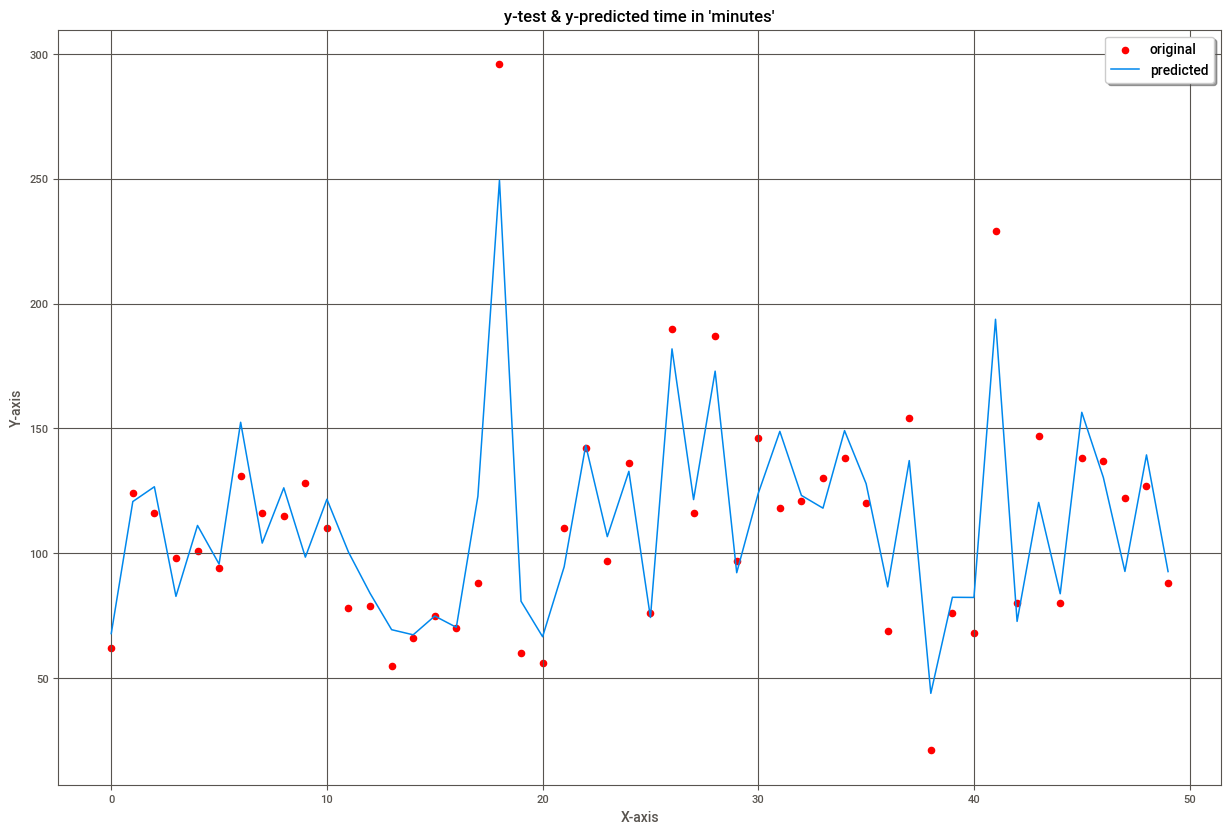

In [103]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

### MinMaxScaler

In [104]:
MODEL_NAME = 'knr_minmaxscaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [ ]:
set_config(print_changed_only=False) 

knr_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('knr', KNeighborsRegressor())])

gs_knr = GridSearchCV(knr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_knr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_knr.best_params_}')
print(f'The {gs_knr.scoring} with the training set of the best parameters is: {gs_knr.score(X_train, y_train)}')
print(f'The {gs_knr.scoring} with the test set of the best parameters is: {gs_knr.score(X_test, y_test)}')

In [ ]:
y_pred = gs_knr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = gs_knr.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("R-squared:", score) 

In [ ]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

### StandardScaler

In [ ]:
MODEL_NAME = 'knr_standardscaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [ ]:
set_config(print_changed_only=False) 

p = [1,2]

knr_pipe = Pipeline([('ss', StandardScaler()),
                     ('knr', KNeighborsRegressor())])

gs_knr = GridSearchCV(knr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_knr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_knr.best_params_}')
print(f'The {gs_knr.scoring} with the training set of the best parameters is: {gs_knr.score(X_train, y_train)}')
print(f'The {gs_knr.scoring} with the test set of the best parameters is: {gs_knr.score(X_test, y_test)}')

In [ ]:
y_pred = gs_knr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = gs_knr.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("R-squared:", score) 

In [ ]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

### RobustScaler

In [ ]:
MODEL_NAME = 'knr_robustscaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [ ]:
set_config(print_changed_only=False) 

p = [1,2]

knr_pipe = Pipeline([('rs', RobustScaler()),
                     ('knr', KNeighborsRegressor())])

gs_knr = GridSearchCV(knr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_knr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_knr.best_params_}')
print(f'The {gs_knr.scoring} with the training set of the best parameters is: {gs_knr.score(X_train, y_train)}')
print(f'The {gs_knr.scoring} with the test set of the best parameters is: {gs_knr.score(X_test, y_test)}')

In [ ]:
y_pred = gs_knr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = gs_knr.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("Score:", score) 

In [ ]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

## K-Neighbors Regressor best Hyper Params

Vamos a hacer uso de los parámetros seleccionados usando el método de GridSearchCV para la selección de hyper parámetros.

Los parámetros seleccionados son:
- `algorithm: auto`
- `leaf_size: 1`
- `n_neighbors: 4`
- `weights: uniform`

## Using Best Hyper Params

In [ ]:
MODEL_NAME = 'knr_best_hyper_params'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
 
knr_pipe = Pipeline([('ss', StandardScaler()),
                     ('knr', KNeighborsRegressor(algorithm = 'auto', 
                            leaf_size = 1, 
                            n_neighbors = 4, 
                            weights = 'uniform') )])

start = time.time()

knr_pipe.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time
print(f"Fitting Time Ellapsed {ellapsed_time} (s)")

y_pred = knr_pipe.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = knr_pipe.score(X_test, y_test)
info[MODEL_NAME]['r2'] = score
print("R-squared:", score)  

x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

# Linear Regression

> Regresión lineal de mínimos cuadrados ordinarios. LinearRegression ajusta un modelo lineal con coeficientes w = (w1, …, wp) para minimizar la suma residual de cuadrados entre los objetivos observados en el conjunto de datos y los objetivos predichos por la aproximación lineal.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

## Scalers

In [ ]:
# Parámetros para GridSearchCV
params = [{'lr__normalize': [True, False],
         'lr__positive': [True, False]}]

### Without Scaler

In [ ]:
MODEL_NAME = 'lr_without_scaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [ ]:
set_config(print_changed_only=False) 


lr_pipe = Pipeline([('lr', LinearRegression())])



gs_lr = GridSearchCV(lr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_lr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_lr.best_params_}')
print(f'The {gs_lr.scoring} with the training set of the best parameters is: {gs_lr.score(X_train, y_train)}')
print(f'The {gs_lr.scoring} with the test set of the best parameters is: {gs_lr.score(X_test, y_test)}')

In [ ]:
y_pred = gs_lr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = gs_lr.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("R-squared:", score) 

In [ ]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

### MinMaxScaler

In [ ]:
MODEL_NAME = 'lr_minmaxscaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [ ]:
set_config(print_changed_only=False) 


lr_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('lr', LinearRegression())])



gs_lr = GridSearchCV(lr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_lr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_lr.best_params_}')
print(f'The {gs_lr.scoring} with the training set of the best parameters is: {gs_lr.score(X_train, y_train)}')
print(f'The {gs_lr.scoring} with the test set of the best parameters is: {gs_lr.score(X_test, y_test)}')

In [ ]:
y_pred = gs_lr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = gs_lr.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("R-squared:", score) 

In [ ]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

### StandardScaler

In [ ]:
MODEL_NAME = 'lr_standardscaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [ ]:
set_config(print_changed_only=False) 

lr_pipe = Pipeline([('ss', StandardScaler()),
                     ('lr', LinearRegression())])

gs_lr = GridSearchCV(lr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_lr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed  {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_lr.best_params_}')
print(f'The {gs_lr.scoring} with the training set of the best parameters is: {gs_lr.score(X_train, y_train)}')
print(f'The {gs_lr.scoring} with the test set of the best parameters is: {gs_lr.score(X_test, y_test)}')

In [ ]:
y_pred = gs_lr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = gs_lr.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("R-squared:", score) 

In [ ]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

### RobustScaler

In [ ]:
MODEL_NAME = 'lr_robustscaler'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [ ]:
set_config(print_changed_only=False) 

lr_pipe = Pipeline([('rs', RobustScaler()),
                     ('lr', LinearRegression())])

gs_lr = GridSearchCV(lr_pipe,
                      param_grid = params,
                      scoring = SCORING,
                      n_jobs = N_JOBS,
                      cv = CV)

start = time.time()

gs_lr.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")
print(f'The parameters of the best model are: {gs_lr.best_params_}')
print(f'The {gs_lr.scoring} with the training set of the best parameters is: {gs_lr.score(X_train, y_train)}')
print(f'The {gs_lr.scoring} with the test set of the best parameters is: {gs_lr.score(X_test, y_test)}')

In [ ]:
y_pred = gs_lr.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = gs_lr.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("R-squared:", score) 

In [ ]:
x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

## Linear Regression best Hyper Params

Vamos a hacer uso de los parámetros seleccionados usando el método de GridSearchCV para la selección de hyper parámetros.

Los parámetros seleccionados son:
- `normalize: True` 
- `positive: False`

## Using Best Hyper Params

In [ ]:
MODEL_NAME = 'lr_best_hyper_params'
info[MODEL_NAME] = {}
info[MODEL_NAME]['model_name'] = MODEL_NAME

lr_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('lr', LinearRegression(normalize = True, 
                            positive = False) )])

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

start = time.time()

lr_pipe.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)
info[MODEL_NAME]['time'] = ellapsed_time

print(f"Fitting Time Ellapsed {ellapsed_time} (s)")

y_pred = lr_pipe.predict(X_test)
info[MODEL_NAME]['y_pred'] = y_pred[:50]

mse = mean_squared_error(y_test, y_pred)
info[MODEL_NAME]['mse'] = mse
print("MSE: ", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
info[MODEL_NAME]['rmse'] = rmse
print("RMSE: ", rmse)

score = lr_pipe.score(X_test, y_test)
info[MODEL_NAME][SCORING] = score
print("R-squared:", score) 

x_ax = range(len(y_test[:50]))
plt.figure(figsize=(15,10))
plt.scatter(x_ax, y_test[:50], s = 20, label="original", color = 'red')
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{REGRESSION_SAMPLE_GRAPHS_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

# Reports

A continuación analizaremos los resultados obtenidos de aplicar diferentes métodos de regresión, centrándonos concretamente en:

- **Tiempo**: tiempo empleado en entrenar el ensemble.
- **Mean Squared Error (MSE)**: Error cuadrático medio de las predicciones respecto a su valor verdadero.
- **Root-mean-square deviation (RMSE)**: Raíz cuadrada del error cuadrático medio o MSE.
- **R2**: Medida de la precisión de los modelos.

In [ ]:
FEATURES = ['model_name', 'time', 'mse', 'rmse', 'r2']
summary_dataframe = pd.DataFrame(columns = FEATURES)

for key in info:
    row = info[key]
    fields = []
    for feature in row:
        if (feature in FEATURES):
            fields.append(row[feature])

    row_series = pd. Series(fields, index = summary_dataframe.columns)
    summary_dataframe = summary_dataframe.append(row_series, ignore_index = True)

SAVE_PATH =  f"{REPORTS_PATH}{MODEL_TIMESTAMP}.csv"

summary_dataframe.to_csv(SAVE_PATH, index = True)
summary_dataframe.style.highlight_min(subset = ['time', 'mse', 'rmse'], color = 'green')\
                       .highlight_max(subset = ['r2'], color = 'green')\
                       .highlight_max(subset = ['time', 'mse', 'rmse'], color = 'red')\
                       .highlight_min(subset = ['r2'], color = 'red')

# Conclusiones

- Los árboles de decisión y los métodos de conjunto no requieren que se realice el escalado de características, ya que no son sensibles a la variación de los datos. Por este motivo a pesar de aplicar diferentes métodos de escalado al hacer `Hyper Parameter Tuning` los mejores parámetros son los mismos y el score proporcionado no varía de un método de escalado a otro. 

- De nuestro reporte podemos sacar como conclusión que el método `Linear Regression` nos proporciona los mejores resultados de predicción. A pesar de haber utilizado `Hyper Parameter Tuning` con pocos parámetros, facilmente podríamos haber hecho una configuración básica para generar nuestro modelo.

- A pesar de que `Linear Regression` nos da los mejores resultados los tiempos de `fitting` que obtenemos no son los mejores, es necesario considerrar la momento de desplegar nuestro sistema si, se valora más la tasa de acierto ó la rápidez para predecir nuevos datos. Estamos dispuestos a sacrificar precisión por rápidez?. En nuestro caso si quisieramos trabajar con apuestas sería más útil ser lo más precisos posibles. Por otro lado, si estuvieramos ante la presencia de un sistema de alta transaccionalidad nos interesaría tener tiempos de respuesta pequeños.

# Bibliografía

https://www.mygreatlearning.com/blog/gridsearchcv/

https://www.datatechnotes.com/2020/10/regression-example-with-decisiontreeregressor.html
